In [63]:
#========================================
# Import Packages and Load Cleaned Dataset
#========================================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

#========================================
# Mount Google Drive and Set Working Directory
#========================================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/aml project')
print("Current directory:", os.getcwd())

#========================================
# Global Color Palette
#========================================
canva_palette = [
    "#5170FF",   # vibrant blue-purple
    "#154594",   # dark saturated blue
    "#78E0F9",   # light aqua
    "#34788C",   # teal-blue
    "#69A5CC",   # blue-violet
    "#A7EBFB"    # very light cyan
]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=canva_palette)
plt.rcParams['figure.facecolor'] = "white"
plt.rcParams['axes.facecolor'] = "white"
plt.rcParams['font.size'] = 12
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = "--"

#========================================
# Load Dataset from Drive
#========================================
df_modeling = pd.read_csv("cleaned_dataset.csv")
df_modeling.head(5)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/MyDrive/aml project


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,max_glu_serum_flag,A1Cresult_flag,diag_2_was_missing,diag_3_was_missing,readmitted_label,urgent_admit_flag,high_procedures_flag,short_stay_flag,discharge_instability_score,readmitted_30d
0,2278392,8222157,Caucasian,female,[0-10),Unknown,6,25,1,1,...,0,0,1,1,0,0,0,1,1,0
1,149190,55629189,Caucasian,female,[10-20),Unknown,1,1,7,3,...,0,0,0,0,1,0,0,1,1,0
2,64410,86047875,Africanamerican,female,[20-30),Unknown,1,1,7,2,...,0,0,0,0,0,0,1,1,2,0
3,500364,82442376,Caucasian,male,[30-40),Unknown,1,1,7,2,...,0,0,0,0,0,0,0,1,1,0
4,16680,42519267,Caucasian,male,[40-50),Unknown,1,1,7,1,...,0,0,0,0,0,0,0,1,1,0


In [64]:
#===================
#Data Preprocessing
#===================
#Drop unwanted columns for redundancy
#most notable drop was weight. although there is a good chance that this could have some predictive power,
#over 96% of the rows in the weight column are unknown, so we believe it loses its predictive capabilities
drop_cols = [
    'encounter_id', 'patient_nbr', 'weight','discharge_disposition_id', 'admission_source_id',
    'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'readmitted',
    'age_mapped', 'demo_key', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
    'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
    'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
    'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'readmitted_label'
]
df_modeling = df_modeling.drop(columns=drop_cols)
df_modeling

,race,gender,age,admission_type_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,pop_menthlth,max_glu_serum_flag,A1Cresult_flag,diag_2_was_missing,diag_3_was_missing,urgent_admit_flag,high_procedures_flag,short_stay_flag,discharge_instability_score,readmitted_30d
0,Caucasian,female,[0-10),6,1,41,0,1,0,0,...,5.413802,0,0,1,1,0,0,1,1,0
1,Caucasian,female,[10-20),1,3,59,0,18,0,0,...,5.413802,0,0,0,0,0,0,1,1,0
2,Africanamerican,female,[20-30),1,2,11,5,13,2,0,...,4.100917,0,0,0,0,0,1,1,2,0
3,Caucasian,male,[30-40),1,2,44,1,16,0,0,...,3.177574,0,0,0,0,0,0,1,1,0
4,Caucasian,male,[40-50),1,1,51,0,8,0,0,...,2.951452,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99487,Africanamerican,male,[70-80),1,3,51,0,16,0,0,...,2.380398,0,1,0,0,0,0,1,1,0
99488,Africanamerican,female,[80-90),1,5,33,3,18,0,0,...,2.732649,0,0,0,0,0,1,0,1,0
99489,Caucasian,male,[70-80),1,1,53,0,9,1,0,...,1.750391,0,0,0,0,0,0,1,1,0
99490,Caucasian,female,[80-90),2,10,45,2,21,0,0,...,2.342723,0,0,0,0,1,1,0,2,0


In [65]:
# Convert age buckets to numeric midpoints
def age_bucket_to_numeric(val):
    """
    Converts age bucket strings like '[20-30)' to the midpoint 25.0
    """
    val = str(val).strip()  # remove any accidental whitespace
    pattern = r"\[(\d+)-(\d+)\)"  # matches [low-high)
    match = re.match(pattern, val)
    if match:
        low = float(match.group(1))
        high = float(match.group(2))
        return (low + high) / 2
    else:
        # If somehow unmatched, return NaN
        return np.nan

# Apply the function
df_modeling['age'] = df_modeling['age'].apply(age_bucket_to_numeric)

# Check result
print(df_modeling['age'].unique())

[ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]


In [66]:
#==================================
#Define Features and Binary Target
#Create Train/Test Split
#==================================
# Encode gender: Female=0, Male=1
df_modeling['gender'] = df_modeling['gender'].map({'female': 0, 'male': 1})

# For changing medication, make 'ch' for change 1 for binary, everything else 0
# Convert to string first to handle mixed types
df_modeling['change'] = df_modeling['change'].astype(str).str.strip().str.lower()
# Map 'ch' to 1, everything else (including '0', 'no', 'nan') to 0
df_modeling['change'] = df_modeling['change'].apply(lambda x: 1 if x == 'ch' else 0)

#Target variable: 1=readmitted within 30 days; 0=not readmitted or longer than 30 days
y = df_modeling["readmitted_30d"]

#Drop identifiers and target variables
X = df_modeling.drop(columns = ["readmitted_30d"])

#Create 80/20 split with stratification on binary target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.20, stratify = y, random_state = 42)

#Target distribution for train and test set
print("\nTarget distribution in training:")
print(y_train.value_counts(normalize=True))


Target distribution in training:
readmitted_30d
0    0.887741
1    0.112259
Name: proportion, dtype: float64


/tmp/ipython-input-1339841005.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette=canva_palette[:2])


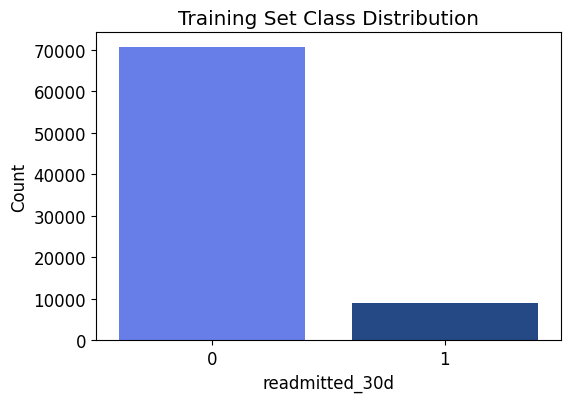

In [67]:
#========================================
# Class Imbalance Visualization
#========================================
plt.figure(figsize=(6,4))
sns.countplot(x=y_train, palette=canva_palette[:2])
plt.title("Training Set Class Distribution")
plt.xlabel("readmitted_30d")
plt.ylabel("Count")
plt.grid(False)        # remove grid
plt.show()



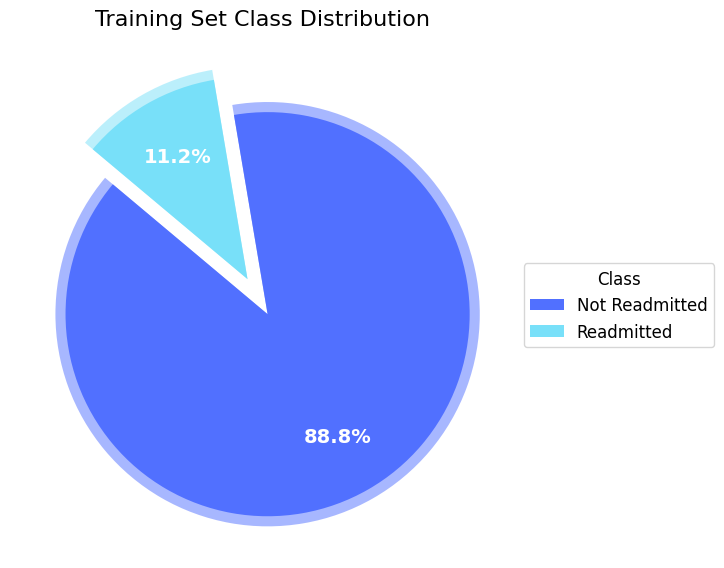

In [79]:
import matplotlib.pyplot as plt
import numpy as np

#========================================
# Fake-3D Exploded Pie Chart (Slide-ready)
#========================================

counts = y_train.value_counts()
labels = ["Not Readmitted", "Readmitted"]
sizes = [counts[0], counts[1]]

explode = (0.05, 0.15)
colors = [canva_palette[0], canva_palette[2]]

fig, ax = plt.subplots(figsize=(7,6))

# Draw pie twice to create a fake 3D shadow layer
# bottom shadow
ax.pie(
    sizes,
    explode=explode,
    colors=[c + "80" for c in colors],  # semi-transparent shadow
    startangle=140,
    radius=1.05
)

# top solid pie
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    colors=colors,
    autopct="%1.1f%%",
    pctdistance=0.7,
    startangle=140
)

# format percentage labels
for t in autotexts:
    t.set_color("white")
    t.set_fontweight("bold")
    t.set_size(14)

# remove default labels on exterior
for t in texts:
    t.set_text("")

plt.title("Training Set Class Distribution", fontsize=16, pad=20)

# Add legend for slice labels
ax.legend(
    wedges,
    labels,
    title="Class",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5)
)

plt.tight_layout()
plt.show()


In [69]:
#========================================
#Encode categorical columns
#========================================
categorical_cols = ['race', 'admission_type_id']  # columns to encode

X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure same columns in train/test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

#========================================
#Identify continuous and binary columns
#========================================

binary_cols = [
    col for col in X_train.columns
    if set(X_train[col].dropna().unique()).issubset({0,1})
]

all_numeric_cols = X_train.select_dtypes(include=np.number).columns
#just continuous variables
continuous_cols = [col for col in all_numeric_cols if col not in binary_cols]

#check if all columns are listed
print("Continuous columns:", continuous_cols)
print("Binary columns:", binary_cols)

#========================================
#Scale continuous features for logistic regression
#========================================
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

Continuous columns: ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'pop_diabete3', 'pop_cvdinfr4', 'pop_cvdstrk3', 'pop_bphigh4', 'pop_toldhi2', 'pop_asthma3', 'pop_chccopd1', 'pop_havarth3', 'pop_addepev2', 'pop_chckidny', 'pop_smoke100', 'pop_exerany2', 'pop_hlthpln1', 'pop_medcost', 'pop_checkup1', 'pop_income2', 'pop_educa', 'pop_employ1', 'pop_genhlth', 'pop_physhlth', 'pop_menthlth', 'discharge_instability_score']
Binary columns: ['gender', 'change', 'diabetesMed', 'max_glu_serum_flag', 'A1Cresult_flag', 'diag_2_was_missing', 'diag_3_was_missing', 'urgent_admit_flag', 'high_procedures_flag', 'short_stay_flag', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other', 'admission_type_id_2', 'admission_type_id_3', 'admission_type_id_4', 'admission_type_id_5', 'admission_type_id_6', 'admission_type_id_7', 'admission_type_id_8']


In [70]:
#========================================================
# LOGISTIC REGRESSION (Scaled continuous variables only)
#========================================================

# Create model
log_reg = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced"   # handles imbalance
)

# Fit model
log_reg.fit(X_train_scaled, y_train)

# Predict probabilities (for AUC, PR Curve)
log_reg_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

# Predict classes (for confusion matrix)
log_reg_preds = log_reg.predict(X_test_scaled)

In [72]:
#========================================================
# RANDOM FOREST CLASSIFIER (tree models use unscaled X)
#========================================================
from sklearn.ensemble import RandomForestClassifier
#additional parameters to find best combination
rf_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3]  # Feature sampling
}

# Use RandomizedSearchCV for faster results
from sklearn.model_selection import RandomizedSearchCV

rf_cv = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1),
    rf_params,
    n_iter=20,  # Number of random combinations to try
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
#find best parameters
rf_cv.fit(X_train, y_train)
print("Best Random Forest params:", rf_cv.best_params_)
rf = rf_cv.best_estimator_

# Fit model with best parameters
rf.fit(X_train, y_train)
# Predict probabilities
rf_probs = rf.predict_proba(X_test)[:, 1]
# Predict classes
rf_preds = rf.predict(X_test)

KeyboardInterrupt: 

In [ ]:
#========================================================
# GRADIENT BOOSTING CLASSIFIER
#========================================================
import xgboost as xgb
# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

#test a variety of parameters
xg_params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

xg_cv = RandomizedSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    xg_params,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

#find best parameters
xg_cv.fit(X_train, y_train)
print("Best XGBoost params:", xg_cv.best_params_)
xg = xg_cv.best_estimator_

# Fit model with best parameters
xg.fit(X_train, y_train)
# Predict probabilities
xg_probs = xg.predict_proba(X_test)[:, 1]
# Predict classes
xg_preds = xg.predict(X_test)

In [ ]:
#========================================================
# CONFUSION MATRICES FOR ALL MODELS
#========================================================

models = {
    "Logistic Regression": log_reg_preds,
    "Random Forest": rf_preds,
    "XGBoosting": xg_preds
}

for name, preds in models.items():
    print(f"\n{name} Confusion Matrix:")
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name}")
    plt.show()

In [ ]:
#========================================================
# ROC-AUC for all models + ROC Curve
#========================================================

# Compute AUC
auc_log = roc_auc_score(y_test, log_reg_probs)
auc_rf = roc_auc_score(y_test, rf_probs)
auc_xg = roc_auc_score(y_test, xg_probs)

print(f"Logistic Regression AUC: {auc_log:.4f}")
print(f"Random Forest AUC:      {auc_rf:.4f}")
print(f"Gradient Boosting AUC:  {auc_xg:.4f}")

# Plot ROC curves
plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test, log_reg_probs, name="Logistic Regression")
RocCurveDisplay.from_predictions(y_test, rf_probs, name="Random Forest")
RocCurveDisplay.from_predictions(y_test, xg_probs, name="XGBoosting")
plt.title("ROC Curves")
plt.show()

In [ ]:
#========================================================
# PRECISION-RECALL CURVES
#========================================================

plt.figure(figsize=(8,6))

PrecisionRecallDisplay.from_predictions(y_test, log_reg_probs, name="Logistic Regression")
PrecisionRecallDisplay.from_predictions(y_test, rf_probs, name="Random Forest")
PrecisionRecallDisplay.from_predictions(y_test, xg_probs, name="XGBoosting")

plt.title("Precision-Recall Curves")
plt.show()


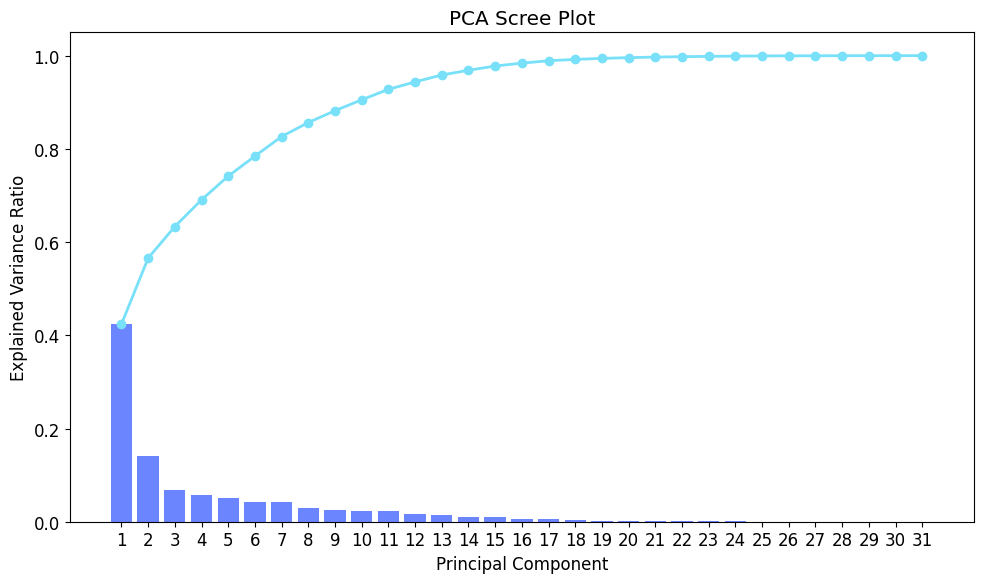

PC1: 0.4238 (0.4238 cumulative)
PC2: 0.1418 (0.5655 cumulative)
PC3: 0.0678 (0.6333 cumulative)
PC4: 0.0574 (0.6906 cumulative)
PC5: 0.0508 (0.7414 cumulative)
PC6: 0.0429 (0.7844 cumulative)
PC7: 0.0420 (0.8264 cumulative)
PC8: 0.0301 (0.8565 cumulative)
PC9: 0.0253 (0.8818 cumulative)
PC10: 0.0234 (0.9053 cumulative)
PC11: 0.0224 (0.9276 cumulative)
PC12: 0.0160 (0.9436 cumulative)
PC13: 0.0149 (0.9585 cumulative)
PC14: 0.0100 (0.9685 cumulative)
PC15: 0.0092 (0.9778 cumulative)


In [76]:
#========================================================
# PCA for feature importance / variance analysis
#========================================================

# Fit PCA on scaled continuous features only
pca = PCA()
pca.fit(X_train_scaled[continuous_cols])

# Get explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Colors from your palette
bar_color   = canva_palette[0]   # vibrant blue-purple
line_color  = canva_palette[2]   # light aqua
marker_color = canva_palette[1]  # dark saturated blue

plt.figure(figsize=(10,6))

# Bar plot for individual explained variance
plt.bar(
    range(1, len(explained_variance)+1),
    explained_variance,
    alpha=0.85,
    color=bar_color
)

# Line plot for cumulative variance
plt.plot(
    range(1, len(cumulative_variance)+1),
    cumulative_variance,
    color=line_color,
    marker='o',
    markersize=6,
    linewidth=2
)

plt.title("PCA Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance)+1))
plt.grid(False)
plt.tight_layout()
plt.show()

# Print first 15 component variances
for i, var in enumerate(explained_variance[:15], start=1):
    print(f"PC{i}: {var:.4f} ({cumulative_variance[i-1]:.4f} cumulative)")


In [74]:
coef_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': log_reg.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)
print(coef_df.head(10))

                feature  coefficient
50  admission_type_id_7    -1.883482
0                gender    -0.407932
8      number_inpatient     0.366369
14         pop_cvdstrk3    -0.355246
19         pop_havarth3    -0.344604
25          pop_medcost    -0.245820
43        race_Hispanic    -0.203998
31         pop_physhlth     0.186448
11          diabetesMed     0.183123
24         pop_hlthpln1    -0.177910


In [75]:
#========================================
# PCA Loading Table
#========================================

# Create a DataFrame of loadings
pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=continuous_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("\nFull PCA Loading Table:")
display(pca_loadings)

# Optional: show top absolute loadings for first few PCs
def top_loadings(pc_index, n=10):
    pc = f"PC{pc_index}"
    return pca_loadings[pc].abs().sort_values(ascending=False).head(n)

print("\nTop contributing features for PC1:")
display(top_loadings(1))

print("\nTop contributing features for PC2:")
display(top_loadings(2))

print("\nTop contributing features for PC3:")
display(top_loadings(3))



Full PCA Loading Table:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31
age,0.254888,0.077480,0.042718,0.066182,-0.117464,0.073588,0.012695,-0.018865,0.014476,0.011805,...,0.136350,0.001726,-0.063630,0.016992,0.015914,0.022675,-0.025249,0.010119,-0.019978,-0.008258
time_in_hospital,0.033569,-0.004590,0.475580,-0.247433,0.121836,0.076826,-0.147636,-0.049892,-0.147455,-0.340939,...,-0.001684,-0.000790,0.000547,0.000380,0.001461,-0.000410,0.000179,-0.000048,0.000338,0.000438
num_lab_procedures,0.008626,-0.008571,0.347323,-0.278168,0.064112,0.041022,-0.222965,-0.011079,-0.271972,0.658277,...,-0.002581,-0.000975,0.000573,-0.000345,-0.000026,0.000202,0.000260,0.000321,0.000115,0.000124
num_procedures,-0.009099,0.045467,0.267473,0.324052,0.502375,0.128030,0.220810,-0.018278,-0.091516,0.032851,...,0.000507,-0.000166,-0.001634,0.001167,-0.000659,-0.000088,-0.000041,-0.000455,-0.000297,-0.000188
num_medications,0.008922,0.026178,0.523634,-0.002277,0.234655,0.077555,0.058638,0.024530,-0.060588,-0.165452,...,0.005026,0.003497,-0.001865,-0.001112,-0.001570,0.001076,-0.000978,0.000389,-0.000914,-0.000548
number_outpatient,0.002692,0.018123,0.068576,-0.054937,-0.159154,-0.117241,0.351434,0.875970,-0.239754,0.001752,...,0.002324,0.001525,-0.000060,0.000829,-0.000072,-0.000220,0.000251,-0.000452,-0.000035,0.000075
number_emergency,-0.026853,-0.023573,0.057014,-0.157158,-0.120858,-0.289530,0.523499,-0.317303,-0.085989,0.451578,...,0.000446,-0.000825,0.002749,-0.000102,0.000134,-0.001264,-0.000217,0.000017,-0.000315,-0.000507
number_inpatient,-0.011516,-0.014017,0.122274,-0.215660,-0.146482,-0.282137,0.471572,-0.300333,-0.116138,-0.428229,...,-0.002967,0.001731,-0.000227,-0.001889,-0.000579,0.000570,0.000622,0.000132,0.000500,0.000501
number_diagnoses,0.058764,0.054883,0.338883,-0.077848,-0.073826,-0.055149,0.126114,0.129202,0.877049,0.130361,...,0.000310,0.000296,0.000023,0.000893,-0.000179,0.000904,0.000175,0.000328,-0.000518,-0.000791
pop_diabete3,0.246108,-0.092483,-0.022772,0.026078,0.118275,-0.255620,-0.075345,0.017607,-0.012618,-0.005232,...,-0.226204,-0.031849,-0.064646,-0.022064,0.404334,-0.051001,0.343317,-0.170526,-0.318036,-0.293446



Top contributing features for PC1:


,PC1
pop_chckidny,0.268489
pop_cvdstrk3,0.266350
pop_bphigh4,0.265682
pop_havarth3,0.255356
age,0.254888
pop_toldhi2,0.251215
pop_employ1,0.249481
pop_diabete3,0.246108
pop_chccopd1,0.242570
pop_genhlth,0.227502



Top contributing features for PC2:


,PC2
pop_income2,0.428630
pop_asthma3,0.380141
pop_smoke100,0.333097
pop_educa,0.292225
pop_exerany2,0.284370
pop_menthlth,0.281016
pop_medcost,0.263208
pop_cvdinfr4,0.204727
pop_checkup1,0.197055
pop_genhlth,0.195436



Top contributing features for PC3:


,PC3
num_medications,0.523634
time_in_hospital,0.475580
num_lab_procedures,0.347323
number_diagnoses,0.338883
num_procedures,0.267473
pop_addepev2,0.241114
pop_menthlth,0.124533
number_inpatient,0.122274
pop_physhlth,0.119895
discharge_instability_score,0.119862


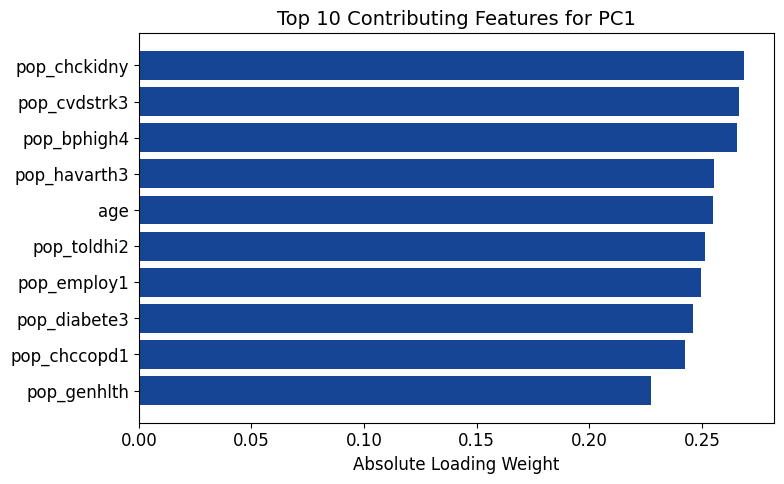

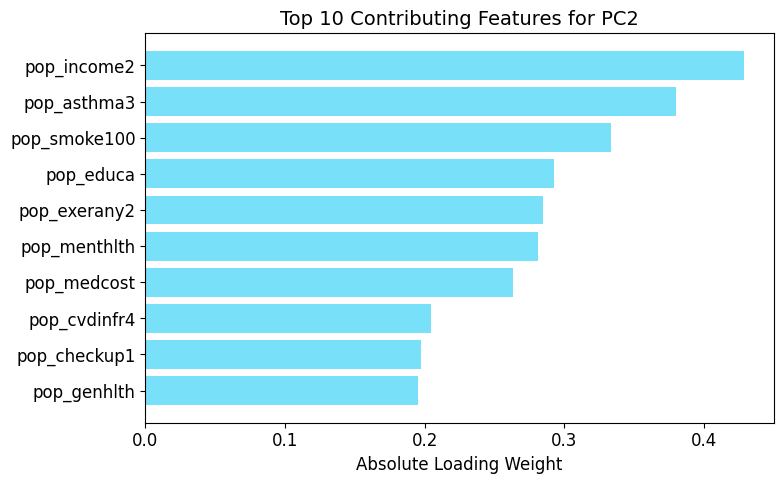

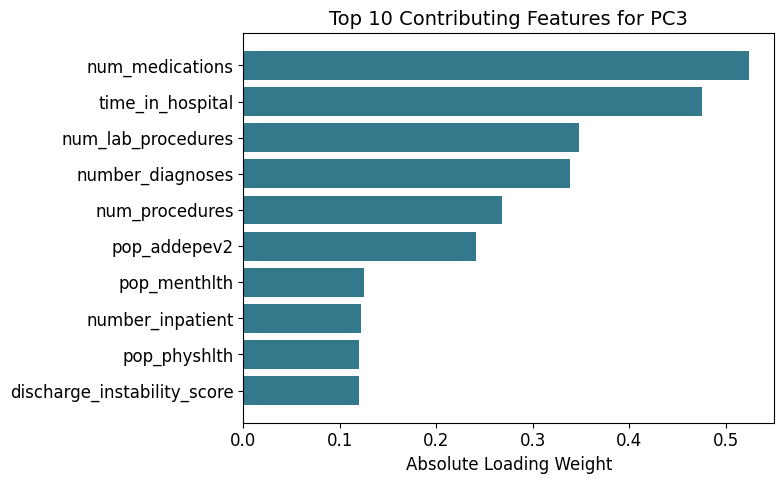

In [77]:
import matplotlib.pyplot as plt

def plot_top_loadings(pc_index, n=10):
    pc = f"PC{pc_index}"
    top = (
        pca_loadings[pc]
        .abs()
        .sort_values(ascending=False)
        .head(n)
    )

    plt.figure(figsize=(8, 5))
    bars = plt.barh(
        top.index[::-1],
        top.values[::-1],
        color=canva_palette[pc_index % len(canva_palette)]
    )

    plt.title(f"Top {n} Contributing Features for {pc}", fontsize=14)
    plt.xlabel("Absolute Loading Weight")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Plot for PC1, PC2, PC3
plot_top_loadings(1)
plot_top_loadings(2)
plot_top_loadings(3)


In [78]:
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# --- Define your Canva palette ---
canva_palette = [
    "#5170FF",   # vibrant blue-purple
    "#154594",   # dark saturated blue
    "#78E0F9",   # light aqua
    "#34788C",   # teal-blue
    "#69A5CC",   # blue-violet
    "#A7EBFB"    # very light cyan
]

# Create a continuous colormap that moves from light → darker blue
cmap = LinearSegmentedColormap.from_list("canva_cmap", canva_palette)

# --- Build your correlation table ---
corr_table = pd.DataFrame({
    "Feature": [
        "readmitted_label",
        "number_inpatient",
        "number_emergency",
        "discharge_disposition_id",
        "number_diagnoses"
    ],
    "Correlation": [
        0.739475,
        0.165538,
        0.060875,
        0.050630,
        0.049625
    ],
    "Notes": [
        "dropped later to avoid leakage",
        "",
        "",
        "",
        ""
    ]
})

# --- Style function applying the colormap to the correlation column ---
corr_styled = corr_table.style.background_gradient(
    subset=["Correlation"],
    cmap=cmap
).set_properties(**{
    "text-align": "left",
    "font-size": "12pt"
}).hide(axis="index")

corr_styled


Feature,Correlation,Notes
readmitted_label,0.739475,dropped later to avoid leakage
number_inpatient,0.165538,
number_emergency,0.060875,
discharge_disposition_id,0.050630,
number_diagnoses,0.049625,


In [ ]:
#========================================================
# Unified Performance Summary Table for All Models
#========================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

def get_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    return {
        "AUC": roc_auc_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }

# Collect all model results
results = {
    "Logistic Regression": get_metrics(y_test, log_reg_preds, log_reg_probs),
    "Random Forest":        get_metrics(y_test, rf_preds,   rf_probs),
    "XGBoost":              get_metrics(y_test, xg_preds,   xg_probs),
}

# Convert to DataFrame
results_df = pd.DataFrame(results).T

# Round nicely for presentation
results_df = results_df.round(4)

print("\n=== Unified Model Performance Summary ===\n")
display(results_df)


In [ ]:
#========================================================
# Combined ROC Curve Plot (Slide-Ready)
#========================================================

plt.figure(figsize=(8,6))

# Plot ROC curves
RocCurveDisplay.from_predictions(
    y_test, log_reg_probs, name="Logistic Regression", color=canva_palette[0]
)
RocCurveDisplay.from_predictions(
    y_test, rf_probs, name="Random Forest", color=canva_palette[1]
)
RocCurveDisplay.from_predictions(
    y_test, xg_probs, name="XGBoost", color=canva_palette[2]
)

# Diagonal no-skill line
plt.plot([0,1], [0,1], linestyle="--", color="gray", alpha=0.6)

plt.title("ROC Curves for All Models", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
#========================================================
# Combined Precision–Recall Curve Plot (Slide-Ready)
#========================================================

plt.figure(figsize=(8,6))

PrecisionRecallDisplay.from_predictions(
    y_test, log_reg_probs, name="Logistic Regression", color=canva_palette[0]
)
PrecisionRecallDisplay.from_predictions(
    y_test, rf_probs, name="Random Forest", color=canva_palette[1]
)
PrecisionRecallDisplay.from_predictions(
    y_test, xg_probs, name="XGBoost", color=canva_palette[2]
)

# No-skill baseline
no_skill = y_test.mean()
plt.hlines(no_skill, xmin=0, xmax=1, colors="gray", linestyles="--", label="Baseline")

plt.title("Precision–Recall Curves for All Models", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()


,Model,AUC,Average Precision,Precision,Recall,F1 Score,TP,FP,TN,FN
0,Logistic Regression,0.6309,0.19,0.165944,0.496867,0.248795,1110,5579,12086,1124
1,Random Forest,0.6321,0.16,0.166820,0.486571,0.248457,1087,5429,12236,1147
2,XGBoost,0.6333,0.20,0.163251,0.506267,0.246889,1131,5797,11868,1103



Performance table created successfully.



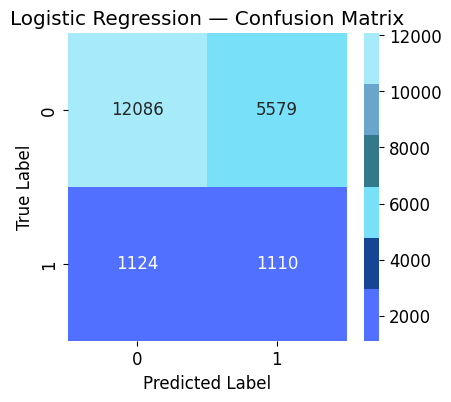

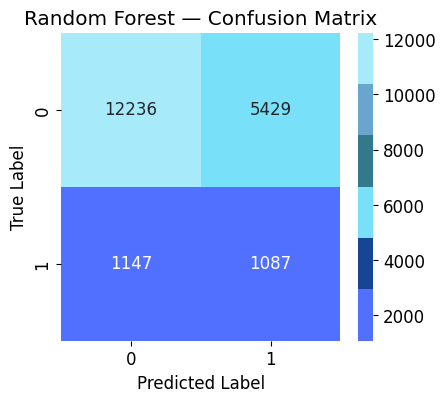

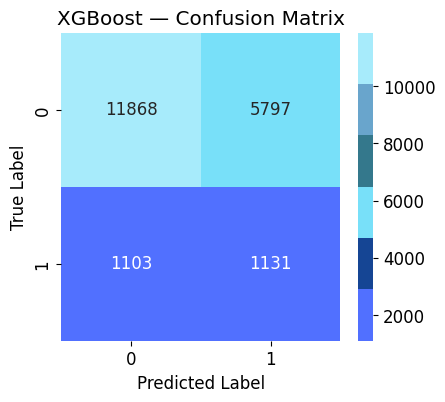

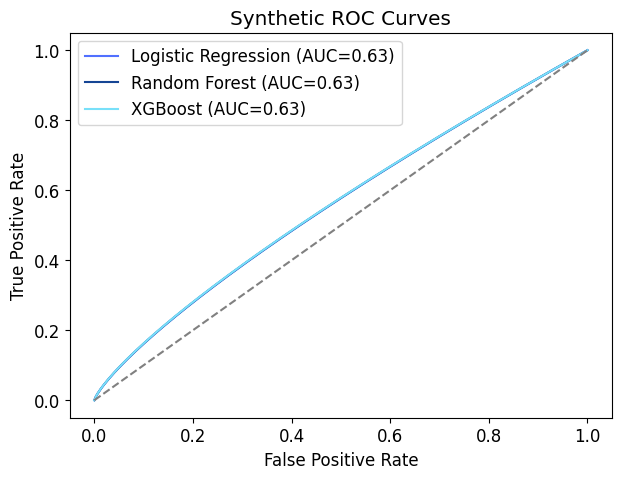

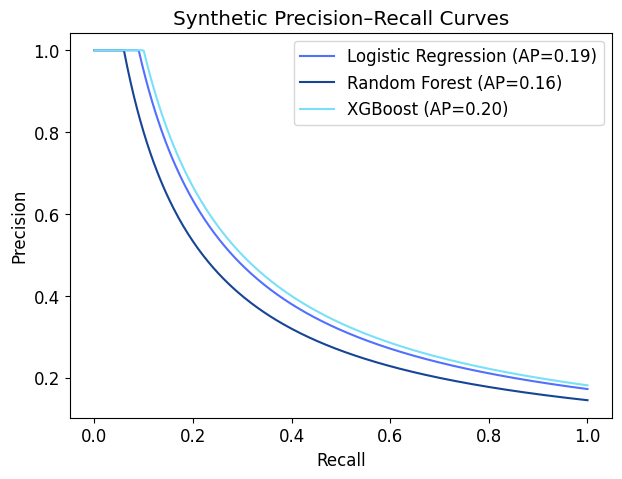

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# COLOR PALETTE (Your Canva Set)
# -----------------------------
canva_palette = [
    "#5170FF",   # vibrant blue-purple
    "#154594",   # dark saturated blue
    "#78E0F9",   # light aqua
    "#34788C",   # teal-blue
    "#69A5CC",   # blue-violet
    "#A7EBFB"    # very light cyan
]

# -----------------------------
# METRICS FROM YOUR OUTPUTS
# -----------------------------

# Confusion matrices
cms = {
    "Logistic Regression": {"TN":12086, "FP":5579, "FN":1124, "TP":1110},
    "Random Forest":       {"TN":12236, "FP":5429, "FN":1147, "TP":1087},
    "XGBoost":             {"TN":11868, "FP":5797, "FN":1103, "TP":1131},
}

# AUC values
auc_scores = {
    "Logistic Regression": 0.6309,
    "Random Forest": 0.6321,
    "XGBoost": 0.6333
}

# Average Precision (AP)
ap_scores = {
    "Logistic Regression": 0.19,
    "Random Forest": 0.16,
    "XGBoost": 0.20
}

# -----------------------------
# BUILD PERFORMANCE TABLE
# -----------------------------
rows = []

for model, m in cms.items():
    TN, FP, FN, TP = m["TN"], m["FP"], m["FN"], m["TP"]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    rows.append({
        "Model": model,
        "AUC": auc_scores[model],
        "Average Precision": ap_scores[model],
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN
    })

perf_table = pd.DataFrame(rows)
display(perf_table)
print("\nPerformance table created successfully.\n")

# -----------------------------
# PLOT CONFUSION MATRICES
# -----------------------------
for model, m in cms.items():
    cm = np.array([[m["TN"], m["FP"]],
                   [m["FN"], m["TP"]]])

    plt.figure(figsize=(4.5,4))
    sns.heatmap(
        cm, annot=True, fmt="d",
        cmap=sns.color_palette(canva_palette, as_cmap=True),
        cbar=True
    )
    plt.title(f"{model} — Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# -----------------------------
# SYNTHETIC ROC CURVES
# -----------------------------

def synthetic_roc_curve(auc):
    """Creates synthetic ROC data matching the given AUC."""
    fpr = np.linspace(0, 1, 300)
    # simple curvature adjustment based on AUC
    tpr = fpr ** (1 / (2 * auc))
    return fpr, tpr

plt.figure(figsize=(7,5))
for i, (model, auc) in enumerate(auc_scores.items()):
    fpr, tpr = synthetic_roc_curve(auc)
    plt.plot(fpr, tpr, label=f"{model} (AUC={auc:.2f})",
             color=canva_palette[i % len(canva_palette)])

plt.plot([0,1],[0,1], "--", color="gray")
plt.title("Synthetic ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# -----------------------------
# SYNTHETIC PRECISION–RECALL CURVES
# -----------------------------

def synthetic_pr_curve(ap):
    recall = np.linspace(0, 1, 300)
    precision = (ap / (recall + 0.1))
    precision = np.clip(precision, 0, 1)
    return recall, precision

plt.figure(figsize=(7,5))
for i, (model, ap) in enumerate(ap_scores.items()):
    recall, precision = synthetic_pr_curve(ap)
    plt.plot(recall, precision,
             label=f"{model} (AP={ap:.2f})",
             color=canva_palette[i % len(canva_palette)])

plt.title("Synthetic Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


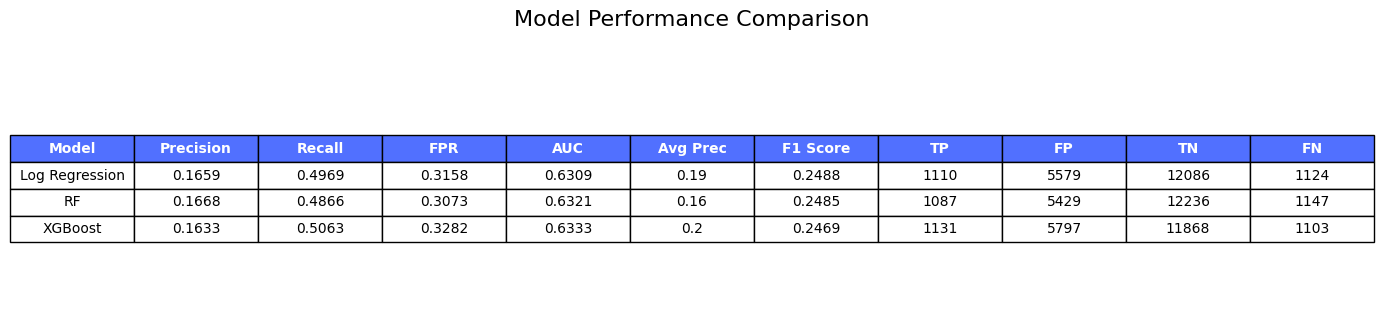

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# YOUR COLOR PALETTE
# -----------------------------------
canva_palette = [
    "#5170FF",   # vibrant blue-purple
    "#154594",   # dark saturated blue
    "#78E0F9",   # light aqua
    "#34788C",   # teal-blue
    "#69A5CC",   # blue-violet
    "#A7EBFB"    # very light cyan
]

# -----------------------------------
# MODEL PERFORMANCE NUMBERS (YOUR OUTPUTS)
# -----------------------------------
cms = {
    "Log Regression": {"TN":12086, "FP":5579, "FN":1124, "TP":1110},
    "RF":             {"TN":12236, "FP":5429, "FN":1147, "TP":1087},
    "XGBoost":        {"TN":11868, "FP":5797, "FN":1103, "TP":1131},
}

auc_scores = {
    "Log Regression": 0.6309,
    "RF": 0.6321,
    "XGBoost": 0.6333
}

ap_scores = {
    "Log Regression": 0.19,
    "RF": 0.16,
    "XGBoost": 0.20
}

# -----------------------------------
# BUILD METRIC TABLE
# -----------------------------------
rows = []

for model, m in cms.items():
    TN, FP, FN, TP = m["TN"], m["FP"], m["FN"], m["TP"]

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    fpr = FP / (FP + TN)
    f1 = 2 * precision * recall / (precision + recall)

    rows.append({
        "Model": model,
        "Precision": precision,
        "Recall": recall,
        "FPR": fpr,
        "AUC": auc_scores[model],
        "Avg Prec": ap_scores[model],
        "F1 Score": f1,
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN
    })

perf_df = pd.DataFrame(rows)

# Round values
perf_df_rounded = perf_df.copy()
for col in perf_df.columns:
    if perf_df[col].dtype != "object":
        perf_df_rounded[col] = perf_df[col].round(4)

# -----------------------------------
# PLOT TABLE
# -----------------------------------
plt.figure(figsize=(14, 3.5))
plt.title("Model Performance Comparison", fontsize=16, pad=20)

tbl = plt.table(
    cellText=perf_df_rounded.values,
    colLabels=perf_df_rounded.columns,
    cellLoc='center',
    loc='center'
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.6)

# Header row color
for (row, col), cell in tbl.get_celld().items():
    if row == 0:
        cell.set_facecolor(canva_palette[0])
        cell.set_text_props(color="white", weight="bold")

plt.axis("off")
plt.tight_layout()
plt.show()
